In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf

In [2]:
batch_size = 64
hidden_units = 900
n_layers = 5
logdir = '/tmp/tf_demo_logs' # Be careful changing this since this directory will be purged when this notebook is run
num_examples = 1000
noise_scale = 0.1
num_epochs = 10
learning_rate = 0.0001
init_scale = 6 / (hidden_units ** 0.5)
nonlinearity = tf.nn.relu

In [3]:
# Clean out old model so changes to definition won't mismatch
if os.path.exists(logdir):
    shutil.rmtree(logdir)

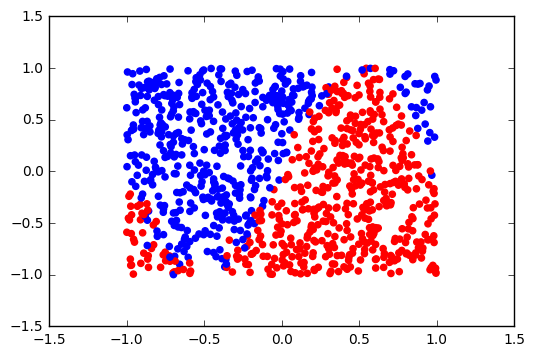

In [4]:
# Generate some noisy training data
x_data = np.random.uniform(-1, 1, size=(num_examples, 2))
label_data = np.array([int(y > np.sin(np.pi * x) + np.random.normal(scale=noise_scale)) for x, y in x_data]) # + np.random.normal(scale=noise_scale, size=num_examples)

def plot(points, labels):
    colors = ['red', 'blue']
    plt.clf()
    plt.scatter(*zip(*points), color=[colors[l] for l in labels])           

plot(x_data, label_data)
plt.show()

# Grid of points for evaluating model
holdout_x = list(itertools.product(np.arange(-1, 1, 0.03), np.arange(-1, 1, 0.03)))

In [5]:
def build_model():
    """Build the model. No actual computation is done here, we're just defining the structure of future computation."""
    # These variables are used to feed data into the graph
    x = tf.placeholder(name='x', shape=(None, 2), dtype=tf.float32)
    labels = tf.placeholder(name='labels', shape=None, dtype=tf.int32)
    
    # Create a list of layer sizes for our network
    layer_sizes = [2] + [hidden_units] * (n_layers - 1)
    
    # For each layer except the last define an affine transformation followed by a nonlinearity
    layer_output = x
    for i, (in_size, out_size) in enumerate(zip(layer_sizes, layer_sizes[1:])):
        with tf.variable_scope('layer' + str(i), reuse=None):
            W = tf.get_variable(name='W' + str(i), shape=(in_size, out_size), dtype=tf.float32)
            b = tf.get_variable(name='b' + str(i), shape=out_size, dtype=tf.float32)
            layer_output = nonlinearity(tf.matmul(layer_output, W) + b)
        
    # Compute two logits for a softmax layer
    with tf.variable_scope('softmax', reuse=None):
        softmax_W = tf.get_variable(name='softmax_W', shape=(hidden_units, 2), dtype=tf.float32)
        softmax_b = tf.get_variable(name='softmax_b', shape=2, dtype=tf.float32)
        logits = tf.matmul(layer_output, softmax_W) + softmax_b
    
    # Instead of explicitly computing softmax, just pass logits to this loss functions
    # It will one loss per example so take the mean over the batch
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
    
    # Predictions are not used during training but are used for evaluation
    predictions = tf.argmax(logits, 1)

    # This node is used to apply gradient information to modify variables
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    
    return x, labels, predictions, loss, train_op

Initial decision boundary:


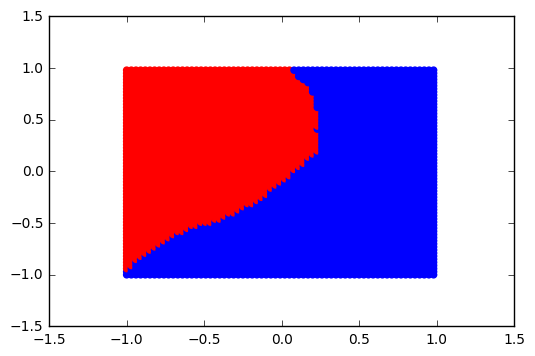

Epoch: 0 Average Loss: 0.6958528945843379


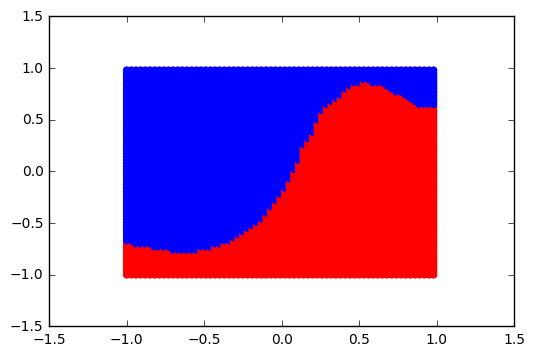

Epoch: 1 Average Loss: 0.24844461282094318


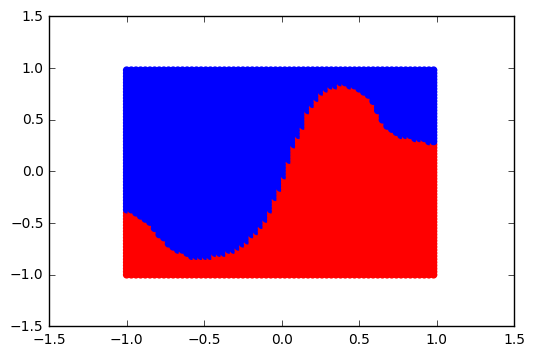

Epoch: 2 Average Loss: 0.12675620168447493


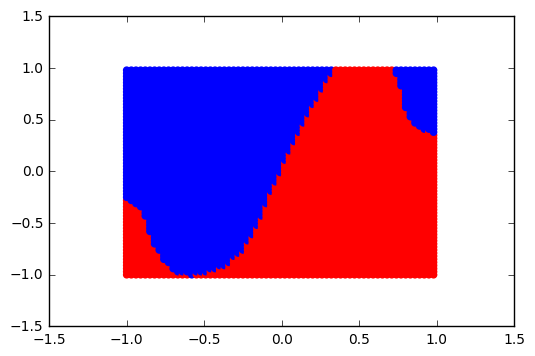

Epoch: 3 Average Loss: 0.11852103223403294


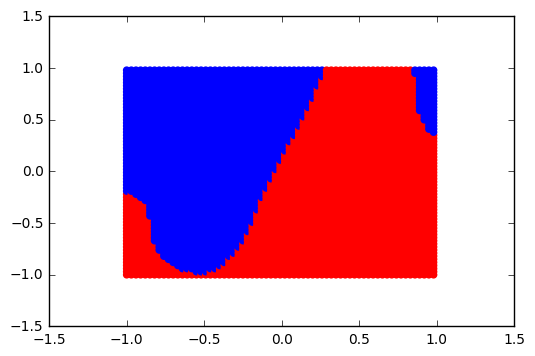

Epoch: 4 Average Loss: 0.1277194768190384


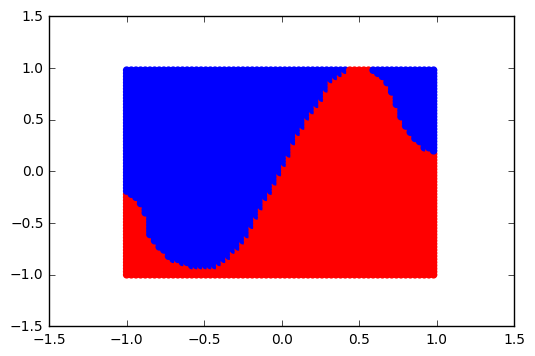

Epoch: 5 Average Loss: 0.09163083682457605


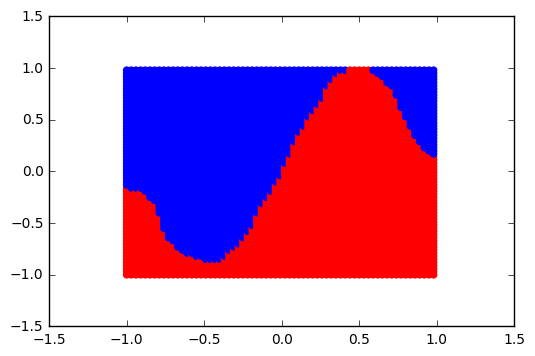

Epoch: 6 Average Loss: 0.09302352716525396


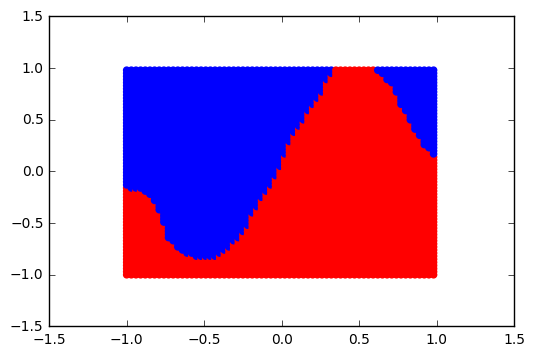

Epoch: 7 Average Loss: 0.10572540462017059


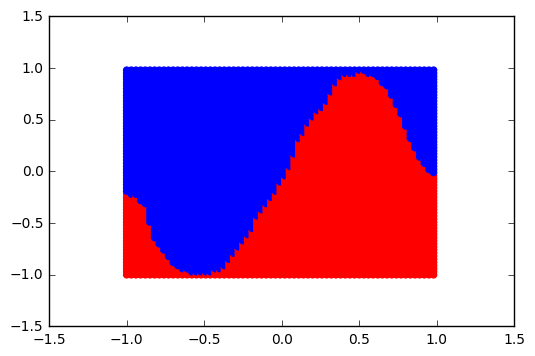

Epoch: 8 Average Loss: 0.08927668581406276


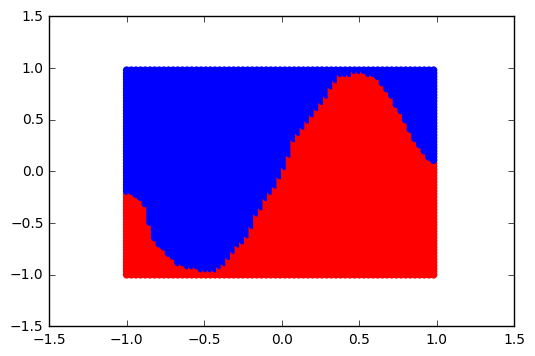

Epoch: 9 Average Loss: 0.07391997848947843


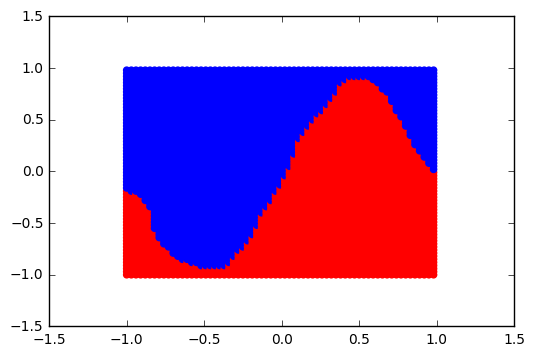

In [6]:
# All variables defined will be put into the default graph
with tf.Graph().as_default():
    # Set a default name prefix and initializer for all variables
    with tf.variable_scope('model', reuse=None, initializer=tf.random_uniform_initializer(minval=-init_scale, maxval=init_scale)):
        x_placeholder, label_placeholder, predictions, loss, train_op = build_model()
    
    # List of indices which will be shuffled for each epoch
    example_order = list(range(num_examples))
    
    # The supervisor automatically saves variable state, and ensures that variables are initialized/loaded
    supervisor = tf.train.Supervisor(logdir=logdir)
    with supervisor.managed_session() as session:
        # Plot the initial (random) decision boundary
        print('Initial decision boundary:')
        feed_dict = {x_placeholder: holdout_x}
        prediction_vals = session.run(predictions, feed_dict=feed_dict)
        plot(holdout_x, prediction_vals)
        plt.show()
        
        
        for epoch in range(num_epochs):
            # Shuffle the order of examples
            np.random.shuffle(example_order)
            steps = 0
            total_loss = 0
            for i in range(num_examples // batch_size):
                # Get the indices for this minibatch
                indices = example_order[i * batch_size : (i + 1) * batch_size]
                # Fetches defines what values in the graph we want to compute
                fetches = {'loss': loss, 'train_op': train_op}
                # A feed_dict defines the values we will insert into the graph
                feed_dict = {x_placeholder: x_data[indices], label_placeholder: label_data[indices]}
                # This is where all the actual computation happens
                output = session.run(fetches=fetches, feed_dict=feed_dict)
                
                steps += 1
                total_loss += output['loss']
            avg_loss = total_loss / steps
            print('Epoch: {} Average Loss: {}'.format(epoch, avg_loss))
                
            # Plot the predicted curve
            feed_dict = {x_placeholder: holdout_x}
            # By not passing train_op in as a fetch, we can run the model without modifying weights
            prediction_vals = session.run(predictions, feed_dict=feed_dict)
            plot(holdout_x, prediction_vals)
            plt.show()